# Normalizing Flows 2: RealNVP on MNIST

## Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Dataset

In [2]:
# ----------------------------
# 1. Data Loading
# ----------------------------
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: x * 2 - 1)  # Scale to [-1, 1]
# ])


transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 1]
    transforms.Lambda(lambda x: (x * 255. + torch.rand_like(x)) / 256.),  # dequantize
    transforms.Lambda(lambda x: x.clamp(min=1e-5, max=1 - 1e-5)),         # avoid 0 or 1
    transforms.Lambda(lambda x: torch.log(x) - torch.log(1 - x)),         # logit(x)
])

# "Dequantizing" makes the data continuous over the interval [0,1), which allows the model to assign meaningful densities...

In [3]:
train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

## Model

In [4]:
# ----------------------------
# 2. Coupling Layer
# ----------------------------
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, mask):
        super().__init__()
        self.mask = mask
        # self.scale_net = nn.Sequential(
        #     nn.Linear(input_dim, 1024),
        #     nn.ReLU(),
        #     nn.Linear(1024, 1024),
        #     nn.ReLU(),
        #     nn.Linear(1024, input_dim)
        # )
        
        # self.translate_net = nn.Sequential(
        #     nn.Linear(input_dim, 1024),
        #     nn.ReLU(),
        #     nn.Linear(1024, 1024),
        #     nn.ReLU(),
        #     nn.Linear(1024, input_dim)
        # )
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.LayerNorm(1024),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.LayerNorm(1024),
            nn.Linear(1024, input_dim),
            # nn.Tanh()  # output in [-1, 1]
        )

        self.translate_net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.LayerNorm(1024),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.LayerNorm(1024),
            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        mask = self.mask.to(x.device)  # Ensure mask is on the same device as x
        x_masked = x * mask
        s = self.scale_net(x_masked) * (1 - mask)
        t = self.translate_net(x_masked) * (1 - mask)
        y = x_masked + (1 - mask) * (x * torch.exp(s) + t)
        log_det_jacobian = ((1 - mask) * s).sum(dim=1)
        return y, log_det_jacobian

    def inverse(self, z):
        mask = self.mask.to(z.device)  # Match mask device with z
        z_masked = z * mask
        s = self.scale_net(z_masked) * (1 - mask)
        t = self.translate_net(z_masked) * (1 - mask)
        x = z_masked + (1 - mask) * ((z - t) * torch.exp(-s))
        return x

# ----------------------------
# 3. RealNVP Model
# ----------------------------
class RealNVP(nn.Module):
    def __init__(self, input_dim, n_coupling_layers):
        super().__init__()
        masks = [self._create_mask(input_dim, even=(i % 2 == 0)) for i in range(n_coupling_layers)]
        self.layers = nn.ModuleList([CouplingLayer(input_dim, mask) for mask in masks])
        self.prior = torch.distributions.Normal(0, 1)

    def _create_mask(self, dim, even=True):
        mask = torch.zeros(dim)
        mask[::2] = 1 if even else 0
        mask[1::2] = 0 if even else 1
        return mask

    def forward(self, x):
        log_det = 0
        for layer in self.layers:
            x, log_det_jacobian = layer(x)
            log_det += log_det_jacobian
        return x, log_det

    def inverse(self, z):
        for layer in reversed(self.layers):
            z = layer.inverse(z)
        return z

    def log_prob(self, x):
        z, log_det = self.forward(x)
        log_pz = self.prior.log_prob(z).sum(dim=1)
        return log_pz + log_det

## Training

In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = RealNVP(input_dim=28*28, n_coupling_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [6]:
# ----------------------------
# 4. Training
# ----------------------------

for epoch in range(200):
    
    model.train()
    total_loss = 0
    
    for x, _ in train_loader:
        
        x = x.view(x.size(0), -1).to(device)
        loss = -model.log_prob(x).mean()
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # clipping gradients (in case of...)
        optimizer.step()
        total_loss += loss.item()

    # scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 1973.6450
Epoch 2, Loss: 1407.5257
Epoch 3, Loss: 1373.1073
Epoch 4, Loss: 1352.0737
Epoch 5, Loss: 1337.9117
Epoch 6, Loss: 1326.1110
Epoch 7, Loss: 1316.1934
Epoch 8, Loss: 1307.6649
Epoch 9, Loss: 1300.2032
Epoch 10, Loss: 1293.0035
Epoch 11, Loss: 1286.7797
Epoch 12, Loss: 1280.8108
Epoch 13, Loss: 1275.1267
Epoch 14, Loss: 1269.9801
Epoch 15, Loss: 1265.2146
Epoch 16, Loss: 1260.4684
Epoch 17, Loss: 1255.8749
Epoch 18, Loss: 1252.1730
Epoch 19, Loss: 1248.0436
Epoch 20, Loss: 1244.7897
Epoch 21, Loss: 1241.5962
Epoch 22, Loss: 1238.2273
Epoch 23, Loss: 1235.0173
Epoch 24, Loss: 1232.2271
Epoch 25, Loss: 1229.3310
Epoch 26, Loss: 1227.0550
Epoch 27, Loss: 1224.2478
Epoch 28, Loss: 1222.1166
Epoch 29, Loss: 1219.5041
Epoch 30, Loss: 1217.7072
Epoch 31, Loss: 1215.3672
Epoch 32, Loss: 1213.4121
Epoch 33, Loss: 1211.5585
Epoch 34, Loss: 1209.5007
Epoch 35, Loss: 1207.6512
Epoch 36, Loss: 1205.9648
Epoch 37, Loss: 1204.2469
Epoch 38, Loss: 1202.6668
Epoch 39, Loss: 1200.

## Results

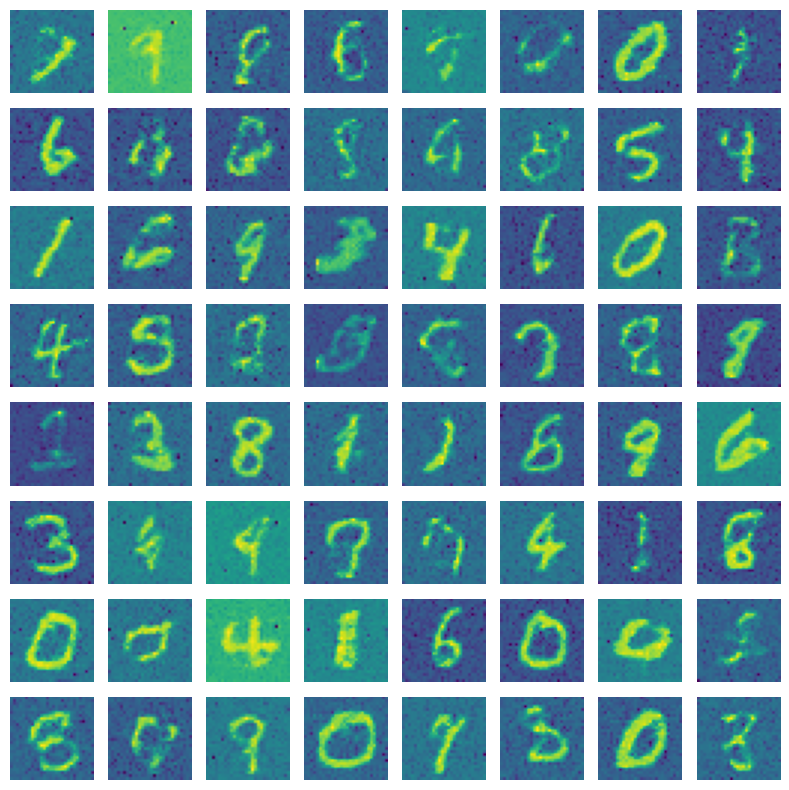

In [13]:
# ----------------------------
# 5. Sampling New Digits
# ----------------------------
model.eval()
with torch.no_grad():
    z = torch.randn(64, 28*28).to(device)
    x_gen = model.inverse(z).cpu().view(-1, 1, 28, 28)

    # Plot
    fig, axs = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            axs[i, j].imshow(x_gen[i*8 + j][0], cmap='viridis')
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

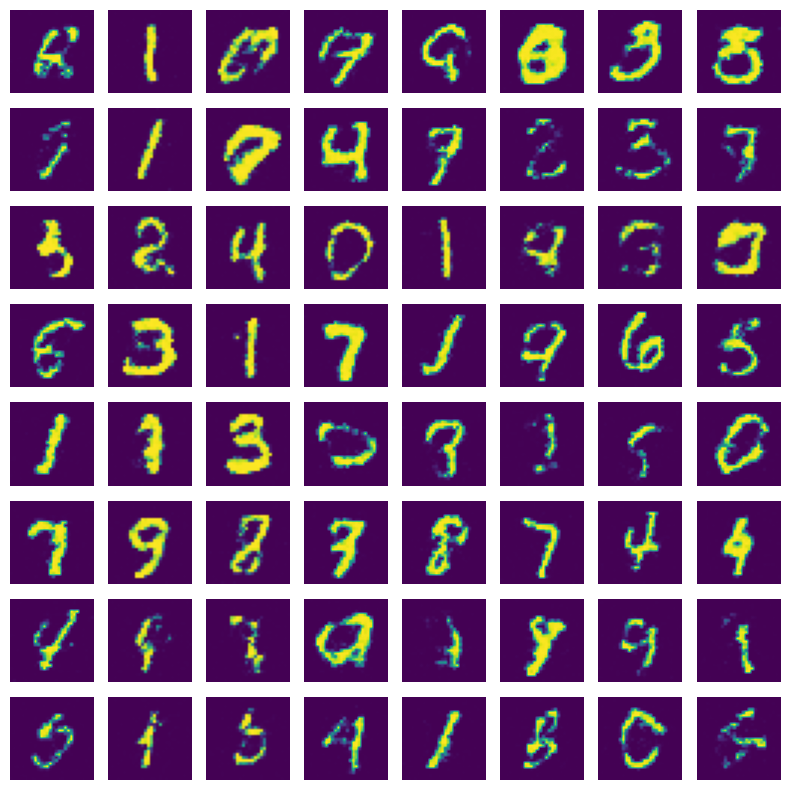

In [15]:
# ----------------------------
# 5. Sampling New Digits
# ----------------------------
model.eval()
with torch.no_grad():
    z = torch.randn(64, 28*28).to(device)  # Prior samples
    x_gen = model.inverse(z)               # Map from latent to image (logit space)
    x_gen = torch.sigmoid(x_gen)           # Inverse of logit -> get back to [0, 1]
    x_gen = x_gen.cpu().view(-1, 1, 28, 28)

    # Plot
    fig, axs = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            axs[i, j].imshow(x_gen[i*8 + j][0], cmap='viridis')
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()